<a href="https://colab.research.google.com/github/vivekp12/dst-group-project-2/blob/main/VivekP/ForConsistency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>[Introduction](#scrollTo=rKCfp20CeRoj)

>[Requirements](#scrollTo=4tjtYwXiTGbg)

>[1.1 Data Augmentation](#scrollTo=Db4dvLsLU0UY)

>[1.2 Train and Test Splitting](#scrollTo=ZP8zGYwkUv6z)

>[Model Training (Base Model)](#scrollTo=mj1aL4LyWNlZ)

>[2.1 Building and training the Model](#scrollTo=hrWYKmiEVr4S)

>[2.2 Train and Test Accuracy](#scrollTo=dQ9sN6o4fVEc)

>[2.3 Plotting Training History](#scrollTo=Uu83BmTBftLA)

>[Paramter Tuning](#scrollTo=XmZNI5WWXyW5)

>[3.1 Regularisation (Batch Normalisation and Dropout)](#scrollTo=mdow1495uRyJ)

>[3.1.1 Building and Training the Model](#scrollTo=EvOT0wmAvAjO)

>[3.1.2 Train and Test Accuracy](#scrollTo=0T3yz2nHvQhY)

>[3.1.3 Plotting Training History](#scrollTo=AuvTYjPtvcO3)

>[3.2 Regularisation (Early Stopping)](#scrollTo=mbpE8SoT077u)

>[3.2.1 Building and Training the Model](#scrollTo=Eh0amf4OYEoV)

>[3.2.2 Train and Test Accuracy](#scrollTo=UbxaFmSlYWMs)

>[3.2.3 Plotting Training History](#scrollTo=n6OdaKHTZUnU)

>[3.3 Learning Rate Scheduler](#scrollTo=Kg2qgirW15y2)

>[3.3.1 Building and Training the Model](#scrollTo=kmXSLbNdZtFe)

>[3.3.2 Train and Test Accuracy](#scrollTo=xi5BDDbIZ7SS)

>[3.3.3 Plotting Training History](#scrollTo=HOI7dj0TaKuX)

>[3.4 Weight Initialisation](#scrollTo=qBTD-GeqP7WE)

>[3.4.1 Building and Training the Model (GlorotUniform())](#scrollTo=q_R_yJjeSQnq)

>[3.4.2 Train and Test Accuracy](#scrollTo=NP3zt-sHSetx)

>[3.4.3 Plotting Training History](#scrollTo=RXaz3ADKSjoN)

>[3.5 Final Model](#scrollTo=jmC4OTcAIKtd)

>[The concept of "Best Model"](#scrollTo=8wNNNn4dRj_1)

>[4.1 Upscaling using the final model](#scrollTo=Jf6fbSlJT87R)

>[Evaluating on Test Data](#scrollTo=ztNRGf3QSsSl)

>[5.1 Base Model](#scrollTo=VNn1p1J946tB)

>[5.2 Model with Regularisation (Batch Normalisation and Dropout)](#scrollTo=EWrhvpbG5pKE)

>[5.3 Model with Regularisation (Early Stopping)](#scrollTo=khKqgst35w_s)

>[5.4 Model with Reduced Learning Rate](#scrollTo=czw6xcZBCbcg)

>[5.5 Model with Xavier Initialisation](#scrollTo=uRcHwNoM52YA)

>[5.6 Final Model](#scrollTo=QVfD-6S3dVJX)

>[5.7 Model for Scaled Image](#scrollTo=YrlqeSkM2kZ6)

>[5.8 Example of any of the model's correct vs incorrect prediction](#scrollTo=UtoSENeX5uPg)

>[Conclusion](#scrollTo=0lU9iP84AF3V)



# Introduction   
The following set of code aims to investigate model creation and performance using neural networks for the [Brain Tumour MRI](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data) dataset consisting of images divided into 4 main categories, glioma, meningioma, no tumour and pituatary, by considering the tanh activation function for a CNN (Convolution Neural Netowrk) model (explained [here](https://github.com/vivekp12/dst-group-project-2/blob/main/MarkM/ConvolutionLayers.ipynb)). We analyze how hyperparamater tuning (in this case learning rate, regularisation, weight initialisation and early stopping) affect model perforamnce by graphical represenations to show training and validation scores and losses. Keeping in mind that on downloading the folder of all the images, it is divided firstly into training and testing folders, one random image from the testing folder is chosen to test the model and evaluate its prediction power (for each hyperparameter tuning, this is done to analyze any relevant changes).   
<br>
While hyperparameter tuning is an important part of this analysis, majority of the importance is given to create a distinction between 3 different activation functions and their effect on the prediction power of the respective models created for the Brain Tumour MRI dataset ([Swish](https://github.com/vivekp12/dst-group-project-2/blob/main/MarkM/Swish_research.ipynb) and [ReLU](https://github.com/vivekp12/dst-group-project-2/blob/main/VivekP/04-ReLUInvestigation.ipynb) being the other 2). The factors in common betweent the 3 projects created is the preprocessing of the data, checking for duplication and the optimizer used, which in this case is the Adam optimizer. The reason for selecting the Adam optimizer is for relatively faster convergence, the robustness allowing it to work well on a wide range of architectures and datasets and bias correction. Adam maintains adaptive learning rate for each parameters by considering two moving averages, the first moment estimate ($m_t$) and the second moment estimate ($v_t$), the former responsible for capturing the mean enabling necessary stabilizing updates, while the latter focuses on the varaince, thereby scaling parametrs. Both consist of inital bias correctors $\hat{m_t}$ and $\hat{v_t}$, which ensure stable estimates during hte initial steps of the training.

<br>

#1. Requirements   
Data augmentation which includes creating a cleaned folder of the training and testing images to have some sort of uniformity with respect to grey scaling of images or fixing dead pixels is performed. It is also observed that duplicates (if any) are checked and removed. This is an integral part for creating neural networks since data can be badly presented and unready for model creation which causes unnatural complexities during compiling, such as underperformance due to noise or even false prediction due to over or under fitting.

# 1.1 Data Augmentation   

In [ ]:
from pathlib import Path  # Import pathlib to work with paths
import kagglehub
import os  # Import os module for file operations
import hashlib
import numpy as np
from tqdm import tqdm
import cv2
import os
import imutils

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

# Convert path to a Path object
path = Path(path)

PROJECT_DIR = path
LABELS = ['pituitary', 'notumor', 'meningioma', 'glioma']
def crop_img(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    return new_img


# Convert 'path' to Path object (already done above)
train_dir = path / "Training"
test_dir = path / "Testing"

if __name__ == "__main__":
    training = train_dir
    testing = test_dir

    training_dir = os.listdir(training)
    testing_dir = os.listdir(testing)

    IMG_SIZE = 256

    for dir in training_dir:
        save_path = Path('cleaned/Training') / dir  # Using pathlib's '/' operator
        path = training / dir  # Using pathlib's '/' operator
        image_dir = os.listdir(path)

        for img in image_dir:
            image = cv2.imread(str(path / img))  # Convert Path to string for OpenCV
            new_img = crop_img(image)
            new_img = cv2.resize(new_img, (IMG_SIZE, IMG_SIZE))

            if not save_path.exists():
                save_path.mkdir(parents=True)

            cv2.imwrite(str(save_path / img), new_img)  # Convert Path to string for OpenCV

    for dir in testing_dir:
        save_path = Path('cleaned/Testing') / dir
        path = testing / dir
        image_dir = os.listdir(path)

        for img in image_dir:
            image = cv2.imread(str(path / img))
            new_img = crop_img(image)
            new_img = cv2.resize(new_img, (IMG_SIZE, IMG_SIZE))

            if not save_path.exists():
                save_path.mkdir(parents=True)

            cv2.imwrite(str(save_path / img), new_img)


Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


In [ ]:
def compute_hash(file):
    hasher = hashlib.md5()
    with open(file, 'rb') as f:
        buf = f.read()
        hasher.update(buf)
    return hasher.hexdigest()


def list_files(hash_dict):
    for data_type in ['Training', 'Testing']:
        for label in LABELS:
            folder_path = os.path.join(PROJECT_DIR, 'data', 'raw', data_type, label)
            for root, dirs, files in os.walk(folder_path):
                for file in files:
                    if file.endswith(".jpg"):
                        file_path = os.path.join(root, file)
                        file_hash = compute_hash(file_path)
                        if file_hash in hash_dict:
                            hash_dict[file_hash].append(file_path)
                        else:
                            hash_dict[file_hash] = [file_path]


def remove_duplicates(hash_dict):
    duplicate_count = 0
    for hash_value, file_paths in hash_dict.items():
        if len(file_paths) > 1:
            for file_path in file_paths[1:]:
                print(f"Removing duplicate (hash : {hash_value}) : {file_path}")
                os.remove(file_path)
                duplicate_count += 1
    print(f"Number of duplicates : {duplicate_count}")


if __name__ == '__main__':
    hash_dict = {}
    list_files(hash_dict)
    remove_duplicates(hash_dict)

Number of duplicates : 0


<br>

# 1.2 Train and Test Splitting  


In this section we aim to use the function __ImageDataGenerator()__ as a means to preprocess the images in both the training and testing folders of the Brain MRI folder. This is done to create changes to images that promotes randomness and allows the model to generalise better on the available data and also on unseen data while testing.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from pathlib import Path
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import classification_report, confusion_matrix

# Define directories for training and testing images
train_dir = Path('cleaned/Training')
test_dir = Path('cleaned/Testing')

# Number of classes
LABELS = ['pituitary', 'notumor', 'meningioma', 'glioma']

# Image size and batch size
IMG_SIZE = 64  # Resize images to 64x64
BATCH_SIZE = 32

# Setup ImageDataGenerators for loading and preprocessing the images
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Random rotation
    width_shift_range=0.1,  # Horizontal shift
    height_shift_range=0.1,  # Vertical shift
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom in and out
    horizontal_flip=True,  # Flip horizontally
    fill_mode='nearest',  # Fill any missing pixels using the nearest pixel
    brightness_range=(0.5, 1.5),  # Randomly adjust brightness between 0.5 and 1.5 times the original
    channel_shift_range=20.0  # Randomly shift RGB channels (intensity)
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Only rescale for test data

# Load images from directories using ImageDataGenerator
print('Training Data: ')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to 64x64
    batch_size=BATCH_SIZE,
    class_mode='categorical', # For multi-class classification
    shuffle=True
)


print('Testing Data: ')
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to 64x64
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Do not shuffle for test data
)


Training Data: 
Found 5712 images belonging to 4 classes.
Testing Data: 
Found 1311 images belonging to 4 classes.


<br>

<br>

# 2. Model Training (Base Model)

# 2.1 Building and training the Model
We use __Convlolution Neural Networks(CNN)__ with the __Tanh activation function__ on multiple input layers and __softmax__ function on the output layer for 4 classes. Model compiling takes place with the __Adam__ optimiser using the loss function as __categorical_crossentropy__ for a multi-class classificaton model consisting of mutliple output layers.   

<br>

__Why the choice of__ __tanh__ __activation function ?__   
While there is no "best" activation function since each of them are used based on the data and the problem at hand, the choice of this activation function is merely for experimental purposes only. As a group each of us have chosen one based on our interests and consequenly an apt amount of research is performed.   
The tanh acitvation function used in neural networks given by:   
<div align="center"> $$ f(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} $$
<br>
<div align="left">
is commonly used in Deep Neural Network (DNN) situtations to represent hidden layers. Also known as Hyperbolic Tangent Activation Function, it transforms input data into the values between -1 and 1 and accomodates the non-linearity between input and output data to learn more complex relationships. It is symmetric around the origin which in leighman's term means assigning negative values to negative data and positive to positive ones. This also means that the gradients are balanced when the weights are updated leading to faster convergence during training, but it is still susceptible to the vanishing gradient problem (gradients approaching zero when input is very large or very small). In backpropagation, each layer computes gradients based on the layer that follows it. If one layer has a very small gradient, it "passes" that small gradient backward, causing the earlier layers to receive even smaller gradients. This effect compounds in deep networks, particularly for networks with many layers.   
<br>
The code and output below shows the usage of the tanh function along with accuracies obtained for both validation and training.   

In [ ]:
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# Build an optimized CNN model
model_base = Sequential([
    Conv2D(64, kernel_size=(3, 3), activation='tanh', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(128, kernel_size=(3, 3), activation='tanh'),
    MaxPooling2D((2, 2)),

    Conv2D(256, kernel_size=(3, 3), activation='tanh'),
    MaxPooling2D((2, 2)),

    Conv2D(512, kernel_size=(3, 3), activation='tanh'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='tanh'),
    Dense(128, activation='tanh'),

    Dense(4, activation='softmax')  # Output layer for 4 classes
])

model_base.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train the model
history_base = model_base.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=100,  # Increased epochs to get better training results
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 28s 116ms/step - accuracy: 0.3764 - loss: 1.4207 - val_accuracy: 0.5188 - val_loss: 1.3150
Epoch 2/100
  1/178 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6875 - loss: 0.8062

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6875 - loss: 0.8062 - val_accuracy: 1.0000 - val_loss: 0.1361
Epoch 3/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 33s 97ms/step - accuracy: 0.6405 - loss: 0.8797 - val_accuracy: 0.6609 - val_loss: 0.8762
Epoch 4/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 125us/step - accuracy: 0.6875 - loss: 0.7183 - val_accuracy: 1.0000 - val_loss: 0.1397
Epoch 5/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 21s 100ms/step - accuracy: 0.7211 - loss: 0.7045 - val_accuracy: 0.7156 - val_loss: 0.7680
Epoch 6/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6562 - loss: 0.8016 - val_accuracy: 0.9355 - val_loss: 0.1724
Epoch 7/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 17s 95ms/step - accuracy: 0.7822 - loss: 0.5715 - val_accuracy: 0.7930 - val_loss: 0.5253
Epoch 8/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - accuracy: 0.8438 - loss: 0.3860 - val_accuracy: 1.0000 - val_loss: 0.0850
Epoch 9/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step - accuracy: 0.8188 - loss: 0.5135 - val_acc

<br>

# 2.2 Train and Test Accuracy  
The test and train accuracy and loss are calucalted to inference on the capability of the neural network model on the given set of images.


In [ ]:
train_score = model_base.evaluate(train_generator)
test_score = model_base.evaluate(test_generator)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

179/179 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - accuracy: 0.9101 - loss: 0.2418
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8113 - loss: 0.5161
Train Loss:  0.2471482902765274
Train Accuracy:  0.9075630307197571
--------------------
--------------------
Test Loss:  0.3586418926715851
Test Accuracy:  0.8642258048057556


<br>

# 2.3 Plotting Training History


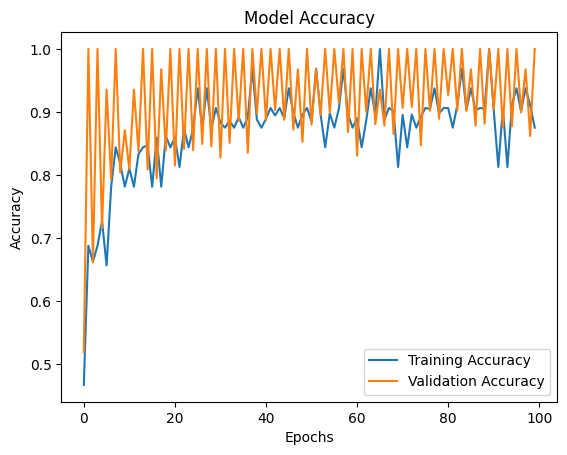

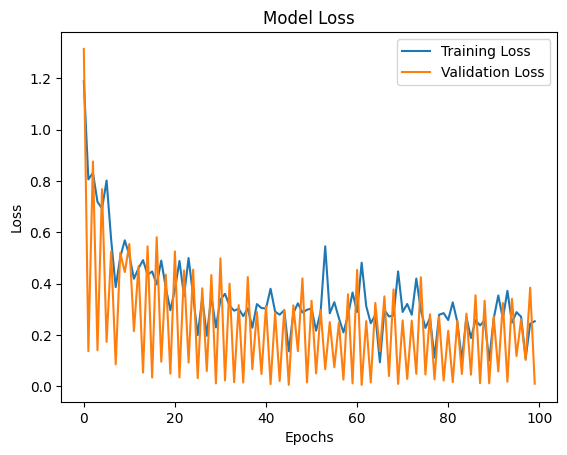

In [ ]:
plt.plot(history_base.history['accuracy'], label='Training Accuracy')
plt.plot(history_base.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history_base.history['loss'], label='Training Loss')
plt.plot(history_base.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The graph here of epochs against accuracy and loss tells for both training and validation data tells us how the model progresses towards improving it's accuracy and reducing its loss with each epoch. It is generally seen that the training accuracy improves are the first few epochs with reaching its high around the 50$^{th}$ epoch. A similar trend could be inferred about the training loss as well. This may imply a discussion on whether 100 epochs could be considered too many, and hence further in the notebook this concept will be tended to. The validation accuracy and loss follows a very peculiar trend of constantly oscillating between values, while still showcasing and overall upward and downward trend for the training and loss scores respectively. The question is why do we see this osccilatory behaviour? While the answer is not obvious, it could be due to multiple underlying reasons, a few of which are excessively high learning rate, insufficient regularization, or noisy training data causing an unstable training process.   
The base model in this case tells us that from [Section 2.2](#scrollTo=dQ9sN6o4fVEc) and [Section 6](#scrollTo=ztNRGf3QSsSl) the model performs on the training (unseen) data by getting good training accuracy for the complete test data and by predicting the image with a high accuracy from the testing folder. Graphically this may not seem the case as there still could be room for improvement by fixing the problems of oscillating validation scores, mentioned before.

In [ ]:
model_base.save('model_base.keras')

<br>

<br>

# 3. Paramter Tuning   


# 3.1 Regularisation (Batch Normalisation and Dropout)   
Regularisation is introduced through __BatchNormalisation()__ and __Dropout=0.5__ to stabilize training and balance the trade-off between keeping enough neurons to learn meaningful patterns and enforcing regularization to prevent overfitting.   
<br>
__Dropout__:   
Overfitting is caused by the network learning patterns in the training data. To recognize these patterns a network will often rely on very a specific combination of weights, which tend to be fragile where removing one of these weights will crumble the combination. Hence why we use dropout.   
To break up these combinations, we randomly drop out some fraction of a layer's input units (neurons or nodes) every step of training, making it much harder for the network to learn those false patterns in the training data. The dropout probability for the nodes is considered as $p$. For instance, if the hidden layers have 2000 neurons (nodes) and a dropout is applied with probability = 0.5, then 1000 neurons would be randomly dropped in every batch. It has to search for broad, general patterns, whose weight patterns tend to be more robust.   
<br>
__BatchNormalisation:__   
A batch normalization layer looks at each batch as it comes in, first normalizing the outputs of the previous hidden layer with its own moving average mean and moving average standard deviation before processing them as inputs for the next hidden layer, and then also putting the data on a new scale with two trainable rescaling parameters beta ($\beta$) and gamma ($\gamma$). These parameters are present in each batchnorm layer, which means multiple hidden and batchnorm layers imply the same amount of parameters both trainable and fixed.
Most often, batchnorm is added as an aid to the optimization process (though it can sometimes also help prediction performance). Models with batchnorm tend to need fewer epochs to complete training. Moreover, batchnorm can also fix various problems that can cause the training to get "stuck".

# 3.1.1 Building and Training the Model

In [ ]:
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# Build an optimized CNN model
model_reg = Sequential([
    Conv2D(64, kernel_size=(3, 3), activation='tanh', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, kernel_size=(3, 3), activation='tanh'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(256, kernel_size=(3, 3), activation='tanh'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(512, kernel_size=(3, 3), activation='tanh'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(512, activation='tanh'),
    Dropout(0.5),  # Adding dropout for regularization
    Dense(128, activation='tanh'),
    Dropout(0.5),  # Adding another dropout layer

    Dense(4, activation='softmax')  # Output layer for 4 classes
])

model_reg.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train the model
history_reg = model_reg.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=100,  # Increased epochs to get better training results
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE
    )

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 34s 132ms/step - accuracy: 0.3036 - loss: 1.8241 - val_accuracy: 0.4602 - val_loss: 1.2519
Epoch 2/100
  1/178 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.3438 - loss: 1.6568

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.3438 - loss: 1.6568 - val_accuracy: 0.0000e+00 - val_loss: 1.8260
Epoch 3/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 18s 98ms/step - accuracy: 0.3331 - loss: 1.5624 - val_accuracy: 0.4305 - val_loss: 1.2348
Epoch 4/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step - accuracy: 0.2500 - loss: 1.5434 - val_accuracy: 0.0000e+00 - val_loss: 1.6070
Epoch 5/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - accuracy: 0.4070 - loss: 1.3219 - val_accuracy: 0.5180 - val_loss: 1.0943
Epoch 6/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 118us/step - accuracy: 0.3750 - loss: 1.2636 - val_accuracy: 0.0000e+00 - val_loss: 1.4218
Epoch 7/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step - accuracy: 0.5440 - loss: 1.0704 - val_accuracy: 0.6500 - val_loss: 0.8656
Epoch 8/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4688 - loss: 1.3779 - val_accuracy: 0.9032 - val_loss: 0.4884
Epoch 9/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - accuracy: 0.6375 - loss: 0.88

<br>

# 3.1.2 Train and Test Accuracy

In [ ]:
train_score = model_reg.evaluate(train_generator)
test_score = model_reg.evaluate(test_generator)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

179/179 ━━━━━━━━━━━━━━━━━━━━ 16s 87ms/step - accuracy: 0.8211 - loss: 0.4983
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7288 - loss: 0.7762
Train Loss:  0.49068790674209595
Train Accuracy:  0.8273809552192688
--------------------
--------------------
Test Loss:  0.543732225894928
Test Accuracy:  0.8154081106185913


<br>

# 3.1.3 Plotting Training History

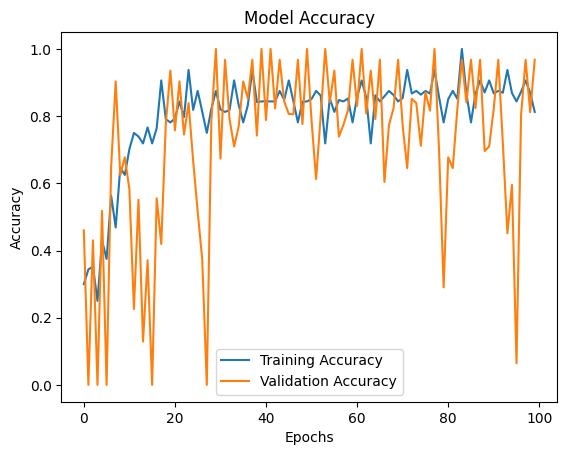

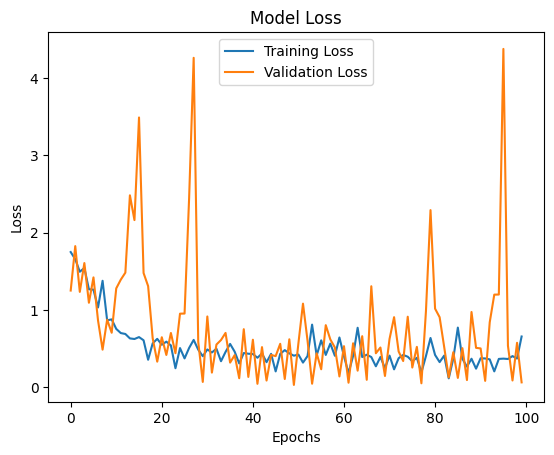

In [ ]:
# Plotting Accuracy
plt.plot(history_reg.history['accuracy'], label='Training Accuracy')
plt.plot(history_reg.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting Loss
plt.plot(history_reg.history['loss'], label='Training Loss')
plt.plot(history_reg.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
 model_reg.save('model_reg.keras')

<br>

<br>

# 3.2 Regularisation (Early Stopping)   
100 epochs may seem like overkill, so using early stopping while monitoring validation loss avoids all 100 epochs to run, preventing overfitting.

# 3.2.1 Building and Training the Model

In [ ]:
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# Build an optimized CNN model
model_early = Sequential([
    Conv2D(64, kernel_size=(3, 3), activation='tanh', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(128, kernel_size=(3, 3), activation='tanh'),
    MaxPooling2D((2, 2)),

    Conv2D(256, kernel_size=(3, 3), activation='tanh'),
    MaxPooling2D((2, 2)),

    Conv2D(512, kernel_size=(3, 3), activation='tanh'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='tanh'),
    Dense(128, activation='tanh'),

    Dense(4, activation='softmax')  # Output layer for 4 classes
])

model_early.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow import keras

# Using Early Stopping as a regularisation technique
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=20,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Print a message when training is stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

In [ ]:
# Train the model
history_early = model_early.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=100,  # Increased epochs to get better training results
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE
    ,callbacks=[early_stopping])

Epoch 1/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 112ms/step - accuracy: 0.3795 - loss: 1.4566 - val_accuracy: 0.6555 - val_loss: 0.9141
Epoch 2/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6875 - loss: 0.7510 - val_accuracy: 0.7742 - val_loss: 0.6706
Epoch 3/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.6225 - loss: 0.8999 - val_accuracy: 0.6281 - val_loss: 0.8822
Epoch 4/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - accuracy: 0.7500 - loss: 0.7173 - val_accuracy: 0.9355 - val_loss: 0.4568
Epoch 5/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 18s 98ms/step - accuracy: 0.7105 - loss: 0.7096 - val_accuracy: 0.7609 - val_loss: 0.6425
Epoch 6/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7188 - loss: 0.6724 - val_accuracy: 1.0000 - val_loss: 0.0877
Epoch 7/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - accuracy: 0.7772 - loss: 0.5950 - val_accuracy: 0.7664 - val_loss: 0.6484
Epoch 8/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 128us/step - accuracy: 0.7812 - loss: 0.67

<br>

# 3.2.2 Train and Test Accuracy

In [ ]:
train_score = model_early.evaluate(train_generator)
test_score = model_early.evaluate(test_generator)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

179/179 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - accuracy: 0.8816 - loss: 0.3342
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7968 - loss: 0.5628
Train Loss:  0.3315470814704895
Train Accuracy:  0.8814775943756104
--------------------
--------------------
Test Loss:  0.3960232734680176
Test Accuracy:  0.8611747026443481


<br>

# 3.2.3 Plotting Training History

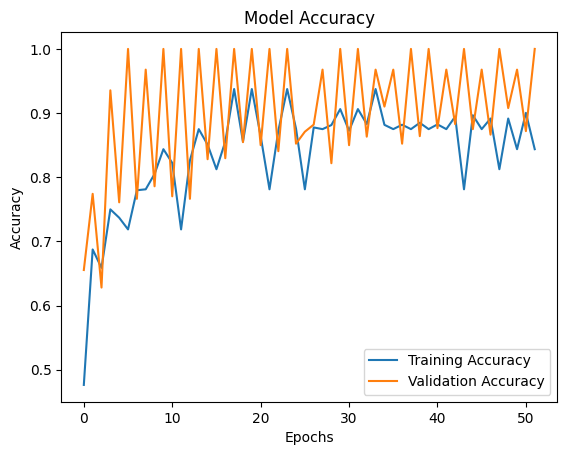

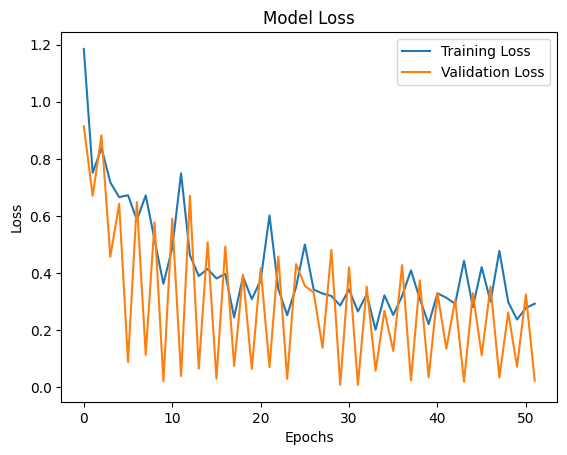

In [ ]:
plt.plot(history_early.history['accuracy'], label='Training Accuracy')
plt.plot(history_early.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history_early.history['loss'], label='Training Loss')
plt.plot(history_early.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<br>

In [ ]:
model_early.save('model_early.keras')

<br>

<br>

# 3.3 Learning Rate Scheduler
We aim to reduce learning rate while monitoring validation loss in order to get optimal training and validation scores. A reduced learning rate in theory optimizes performance by forcing the optimizer to make smaller adjustments, fine-tuning parameters for better performance. This inturn stabilizes training and overall performance. Here we have only considered the [ReduceLROnPlateau](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau) scheduler into consideration, while some other schedulers include Step Decay, Exponential Decay, Cosine Annealing, etc.

# 3.3.1 Building and Training the Model

In [ ]:
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# Build an optimized CNN model
model_reduce_lr = Sequential([
    Conv2D(64, kernel_size=(3, 3), activation='tanh', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(128, kernel_size=(3, 3), activation='tanh'),
    MaxPooling2D((2, 2)),

    Conv2D(256, kernel_size=(3, 3), activation='tanh'),
    MaxPooling2D((2, 2)),

    Conv2D(512, kernel_size=(3, 3), activation='tanh'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='tanh'),
    Dense(128, activation='tanh'),

    Dense(4, activation='softmax')  # Output layer for 4 classes
])

model_reduce_lr.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow import keras

# Using ReduceLROnPlateau as a learning rate scheduler
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.1,  # Factor by which the learning rate will be reduced
    patience=10,  # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,  # Print messages when learning rate is reduced
    min_delta=0.0001, # Minimum change in the monitored quantity to qualify as an improvement.
    cooldown=0, # Number of epochs to wait before resuming normal operation after lr has been reduced.
    min_lr=0,  # Lower bound on the learning rate.
)

In [ ]:
# Train the model
history_reduce_lr = model_reduce_lr.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=100,  # Increased epochs to get better training results
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE
    ,callbacks=[reduce_lr])

Epoch 1/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 22s 105ms/step - accuracy: 0.3959 - loss: 1.3905 - val_accuracy: 0.5867 - val_loss: 1.0393 - learning_rate: 0.0010
Epoch 2/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3750 - loss: 1.2660 - val_accuracy: 0.9677 - val_loss: 0.2676 - learning_rate: 0.0010
Epoch 3/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.6617 - loss: 0.8422 - val_accuracy: 0.6672 - val_loss: 0.9170 - learning_rate: 0.0010
Epoch 4/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - accuracy: 0.6875 - loss: 0.7459 - val_accuracy: 0.9355 - val_loss: 0.1583 - learning_rate: 0.0010
Epoch 5/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.7510 - loss: 0.6569 - val_accuracy: 0.7922 - val_loss: 0.5489 - learning_rate: 0.0010
Epoch 6/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - accuracy: 0.8125 - loss: 0.4486 - val_accuracy: 0.8065 - val_loss: 0.5135 - learning_rate: 0.0010
Epoch 7/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.77

<br>

# 3.3.2 Train and Test Accuracy

In [ ]:
train_score = model_reduce_lr.evaluate(train_generator)
test_score = model_reduce_lr.evaluate(test_generator)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

179/179 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - accuracy: 0.9521 - loss: 0.1359
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9105 - loss: 0.2938
Train Loss:  0.1348697543144226
Train Accuracy:  0.9527310729026794
--------------------
--------------------
Test Loss:  0.20297753810882568
Test Accuracy:  0.936689555644989


<br>

# 3.3.3 Plotting Training History

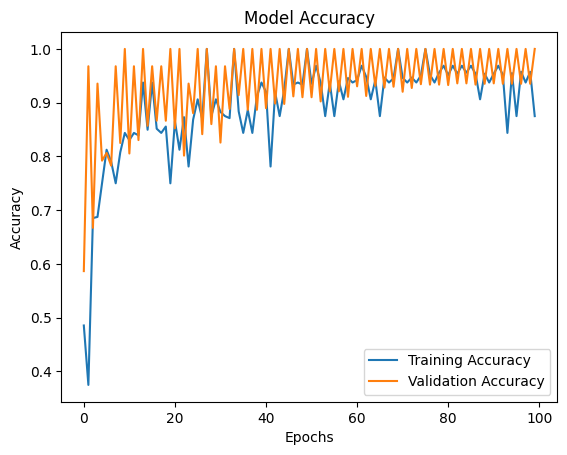

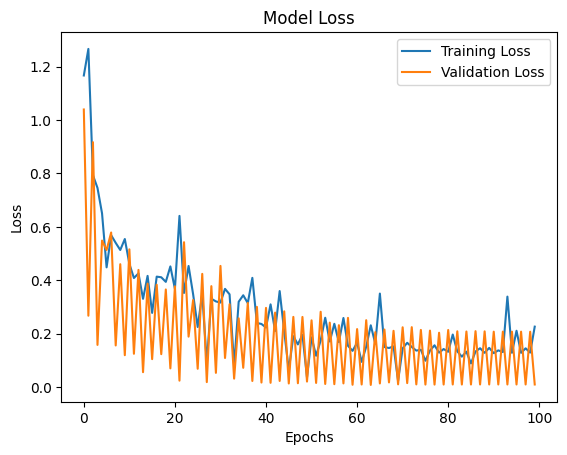

In [ ]:
#Plotting Accuracy
plt.plot(history_reduce_lr.history['accuracy'], label='Training Accuracy')
plt.plot(history_reduce_lr.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Plotting Loss
plt.plot(history_reduce_lr.history['loss'], label='Training Loss')
plt.plot(history_reduce_lr.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<br>

In [ ]:
model_reduce_lr.save('model_reduce_lr.keras')

<br>

<br>

# 3.4 Weight Initialisation   
Here we use Xavier Initialisation also known as __Glorot Initialisation__ which is a weight initialisation methods ([more info on weight initialisation here]() that ensures constant variance of inputs and outputs (Glorot Uniform is considered here) of each layer. It is mostly used in conjuntion with __tanh__ activation function to tackle the vanishing or exploding gradient problem common in deep networks. The function in python for Xavier Initialisation is [GlorotUniform()]((https://www.tensorflow.org/api_docs/python/tf/keras/initializers/GlorotUniform) and it draws samples from a uniform distribution within $ [-limit, limit] $, where $$ limit = \sqrt{\frac{6}{fan_{in} + fan_{out}}} $$
<br>
$ fan_{in} $ is the number of input units in the weight tensor and $ fan_{out} $ is the number of output units,   
The likes of other initialisation techniques like He and LeCun will not improve training and validation accuracy due to the fact that they were built primarily for activation functions like ReLU and sigmoid to solve the vanishing or exploding gradient porblems in those cases.

# 3.4.1 Building and Training the Model (GlorotUniform())

In [ ]:
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform

# Build an optimized CNN model
model_xavier = Sequential([
    Conv2D(64, kernel_size=(3, 3), activation='tanh', input_shape=(64, 64, 3), kernel_initializer=GlorotUniform()),
    #using the glorot initialiser at each layer
    MaxPooling2D((2, 2)),

    Conv2D(128, kernel_size=(3, 3), activation='tanh', kernel_initializer=GlorotUniform()),
    MaxPooling2D((2, 2)),

    Conv2D(256, kernel_size=(3, 3), activation='tanh', kernel_initializer=GlorotUniform()),
    MaxPooling2D((2, 2)),

    Conv2D(512, kernel_size=(3, 3), activation='tanh', kernel_initializer=GlorotUniform()),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='tanh', kernel_initializer=GlorotUniform()),
    Dense(128, activation='tanh', kernel_initializer=GlorotUniform()),

    Dense(4, activation='softmax')  # Output layer for 4 classes
])

model_xavier.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train the model
history_xavier = model_xavier.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=100,  # Increased epochs to get better training results
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 27s 120ms/step - accuracy: 0.3719 - loss: 1.4982 - val_accuracy: 0.6547 - val_loss: 0.9157
Epoch 2/100
  1/178 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7188 - loss: 0.8086

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7188 - loss: 0.8086 - val_accuracy: 0.6774 - val_loss: 0.7493
Epoch 3/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 41s 143ms/step - accuracy: 0.6439 - loss: 0.8787 - val_accuracy: 0.6758 - val_loss: 0.8577
Epoch 4/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 132us/step - accuracy: 0.6250 - loss: 0.8257 - val_accuracy: 0.9355 - val_loss: 0.2956
Epoch 5/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 36s 117ms/step - accuracy: 0.7287 - loss: 0.7029 - val_accuracy: 0.7625 - val_loss: 0.6834
Epoch 6/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 181us/step - accuracy: 0.7188 - loss: 0.6900 - val_accuracy: 1.0000 - val_loss: 0.1089
Epoch 7/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - accuracy: 0.7908 - loss: 0.5466 - val_accuracy: 0.8133 - val_loss: 0.5145
Epoch 8/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 131us/step - accuracy: 0.8125 - loss: 0.5774 - val_accuracy: 1.0000 - val_loss: 0.0356
Epoch 9/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - accuracy: 0.8007 - loss: 0.5249 - va

<br>

# 3.4.2 Train and Test Accuracy

In [ ]:
train_score = model_xavier.evaluate(train_generator)
test_score = model_xavier.evaluate(test_generator)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

179/179 ━━━━━━━━━━━━━━━━━━━━ 16s 87ms/step - accuracy: 0.9184 - loss: 0.2381
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8311 - loss: 0.4532
Train Loss:  0.2449316829442978
Train Accuracy:  0.911939799785614
--------------------
--------------------
Test Loss:  0.30980557203292847
Test Accuracy:  0.8878718614578247


<br>

# 3.4.3 Plotting Training History

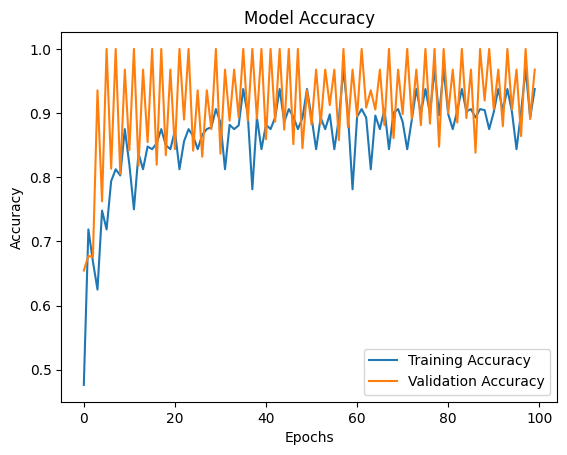

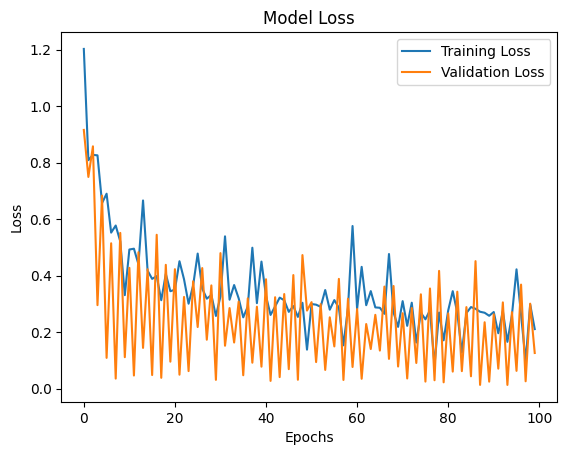

In [ ]:
#Plotting Accuracy
plt.plot(history_xavier.history['accuracy'], label='Training Accuracy')
plt.plot(history_xavier.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Plotting Loss
plt.plot(history_xavier.history['loss'], label='Training Loss')
plt.plot(history_xavier.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model_xavier.save('model_xavier.keras')

<br>

<br>

# 3.5 Final Model   
The final model includes all the parameter tunings we have so far investigated which includes Learning Rate Scheduler (ReduceLROnPlateau), Weight Initialiser (Xavier Initialiser) and Regularisation (Batch Normalisation, Early Stopping, Dropout) to create a more advanced model capable of solving the problems we faced previously such as vanishing gradients, slow convergence, unstable training, poor generalising on unseen data, and even to an extent robustness, simultanously for better overall model performance.

In [ ]:
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform

# Build an optimized CNN model by including all parameter tunings, GlorotUniform(),BatchNormalisation(),Dropout()
model_final = Sequential([
    Conv2D(64, kernel_size=(3, 3), activation='tanh', input_shape=(64, 64, 3), kernel_initializer=GlorotUniform()),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, kernel_size=(3, 3), activation='tanh', kernel_initializer=GlorotUniform()),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(256, kernel_size=(3, 3), activation='tanh', kernel_initializer=GlorotUniform()),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(512, kernel_size=(3, 3), activation='tanh', kernel_initializer=GlorotUniform()),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(512, activation='tanh', kernel_initializer=GlorotUniform()),
    Dropout(0.5),
    Dense(128, activation='tanh', kernel_initializer=GlorotUniform()),
    Dropout(0.5),

    Dense(4, activation='softmax')  # Output layer for 4 classes
])

model_final.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Include learning rate scheduler and early stopping regularisation before model fitting
from tensorflow import keras

#Regularisation
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    restore_best_weights=True
)

#Learning Rate Scheduler
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    verbose=1,
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)

In [ ]:
# Train the model
history_final = model_final.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=100,  # Increased epochs to get better training results
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE
    ,callbacks=[reduce_lr])

Epoch 1/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 31s 122ms/step - accuracy: 0.3046 - loss: 1.7715 - val_accuracy: 0.3375 - val_loss: 1.3385 - learning_rate: 0.0010
Epoch 2/100
  1/178 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5000 - loss: 1.3198

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5000 - loss: 1.3198 - val_accuracy: 0.0000e+00 - val_loss: 1.6218 - learning_rate: 0.0010
Epoch 3/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.4007 - loss: 1.4474 - val_accuracy: 0.5188 - val_loss: 1.0564 - learning_rate: 0.0010
Epoch 4/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.4375 - loss: 1.3297 - val_accuracy: 0.2581 - val_loss: 1.3957 - learning_rate: 0.0010
Epoch 5/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 19s 95ms/step - accuracy: 0.4984 - loss: 1.1750 - val_accuracy: 0.6000 - val_loss: 0.9921 - learning_rate: 0.0010
Epoch 6/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 135us/step - accuracy: 0.7188 - loss: 0.9451 - val_accuracy: 0.6129 - val_loss: 0.9607 - learning_rate: 0.0010
Epoch 7/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - accuracy: 0.5781 - loss: 0.9923 - val_accuracy: 0.6953 - val_loss: 0.8471 - learning_rate: 0.0010
Epoch 8/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 104us/step - accuracy: 0.6562 - loss

<br>

In [ ]:
train_score = model_final.evaluate(train_generator)
test_score = model_final.evaluate(test_generator)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

179/179 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.9067 - loss: 0.2682
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7890 - loss: 0.6708
Train Loss:  0.25888973474502563
Train Accuracy:  0.9096638560295105
--------------------
--------------------
Test Loss:  0.4863147735595703
Test Accuracy:  0.845919132232666


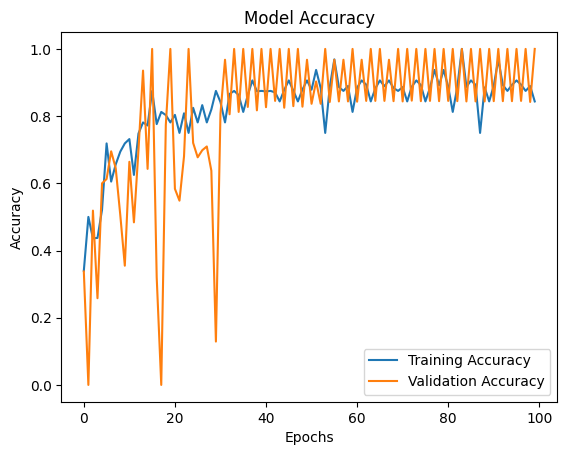

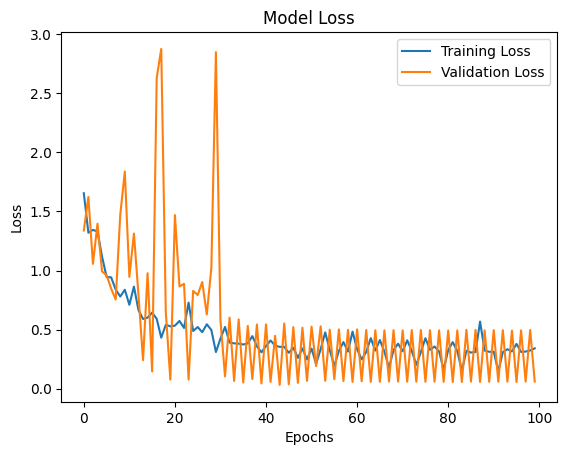

In [ ]:
# Plotting Accuracy
plt.plot(history_final.history['accuracy'], label='Training Accuracy')
plt.plot(history_final.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting Loss
plt.plot(history_final.history['loss'], label='Training Loss')
plt.plot(history_final.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

It is clear that the final model does extremely well to relatively improve the "oscillation" problem that we have consistently faced throughout, by evidence of the training and validation accuracies and losses noow oscillating with a smaller range. The overall performance of the model although not as good as some of the trained models here for instance the [LR scheduler](#scrollTo=Kg2qgirW15y2) or even the [base model](#scrollTo=mj1aL4LyWNlZ), still can be considered as acceptable and performs well on unseen data (i.e. training data). Further analysis by looking at various other paramters that can be tuned can enhance model performance and generalisation but due to computational resitrictions, we will stop here.

In [ ]:
model_final.save('model_final.keras')

<br>

<br>

# 4. The concept of "Best Model"   
While all models considered here have their own benefits, for instance the early stopping model providing lesser number of epochs for faster training, the model with xavier initialisation trying to solve the vanishing gradient problem, regularisation model preventing overfitting, and the model with all hyperparameters tuned showing multiple benefits, it is clear by the training accuracy of 0.9366 that the reduced LR model has generalised better on this particular test data. While we cannot conclusively tag it to be the "best" model in a more general sense, for our current problem, we shall consider the [final model](#scrollTo=jmC4OTcAIKtd) which we have developed using all the possible parameter tunings.   
Hence, while the Reduce LR model considering ReduceLROnPlateau scheduler offers a good balance between model performance and complexity, the most optimal model that takes care of overfitting, improves convergence speed, and overall helps in understanding the data on a deeper sacale is the [final model](#scrollTo=jmC4OTcAIKtd), making it more suitable than the other models that have been trained.

<br>

# 4.1 Upscaling using the final model
With the information about the best model in hand, we now aim to upscale our research from the perspective of smaller size images, originally chosen as 64x64, to a 128x128 size. This will not only inform us if the model we have chosen makes sense in aa upscaled version of our original findings, but also if the current environment we have chosen with the computational limitations will be able to handle the greater load of compiling a large set of heavy images.   
The data augmentation process will not have any specific changes except for changing the image size.

In [ ]:
train_dir = Path('cleaned/Training')
test_dir = Path('cleaned/Testing')

LABELS = ['pituitary', 'notumor', 'meningioma', 'glioma']


IMG_SIZE = 128  # Upscaled image being the only change to the data augmentation process
BATCH_SIZE = 32


train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=(0.5, 1.5),
    channel_shift_range=20.0
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)


print('Training Data: ')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE), # Image size is now 128x128
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)


print('Testing Data: ')
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),  # Image size is now 128x128
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Training Data: 
Found 5712 images belonging to 4 classes.
Testing Data: 
Found 1311 images belonging to 4 classes.


<br>

In [ ]:
# We use the CNN architecture of the final model in this case to train on the upscaled images

from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
model_scaled = Sequential([
    Conv2D(64, kernel_size=(3, 3), activation='tanh', input_shape=(128, 128, 3),kernel_initializer=GlorotUniform()),
    # #input_shape changed from (64,53,3) to (128,128,3) given image size is scaled.
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, kernel_size=(3, 3), activation='tanh',kernel_initializer=GlorotUniform()),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(256, kernel_size=(3, 3), activation='tanh',kernel_initializer=GlorotUniform()),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(512, kernel_size=(3, 3), activation='tanh',kernel_initializer=GlorotUniform()),
    MaxPooling2D((2, 2)),
    BatchNormalization(),


    Flatten(),
    Dense(512, activation='tanh', kernel_initializer=GlorotUniform()),
    Dropout(0.5),
    Dense(128, activation='tanh', kernel_initializer=GlorotUniform()),
    Dropout(0.5),

    Dense(4, activation='softmax')  # Output layer for 4 classes
])

model_scaled.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Learning Rate Scheduler
from tensorflow import keras
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    verbose=1,
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)

In [ ]:
# Train the model
history_scaled = model_scaled.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=100,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE
    ,callbacks=[reduce_lr])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 55s 242ms/step - accuracy: 0.3113 - loss: 1.8020 - val_accuracy: 0.4055 - val_loss: 1.2957 - learning_rate: 0.0010
Epoch 2/100
  1/178 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.3750 - loss: 1.7284

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3750 - loss: 1.7284 - val_accuracy: 0.0000e+00 - val_loss: 1.8159 - learning_rate: 0.0010
Epoch 3/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 65s 203ms/step - accuracy: 0.3005 - loss: 1.5952 - val_accuracy: 0.5266 - val_loss: 1.1367 - learning_rate: 0.0010
Epoch 4/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2500 - loss: 1.5212 - val_accuracy: 0.0000e+00 - val_loss: 1.7978 - learning_rate: 0.0010
Epoch 5/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 37s 204ms/step - accuracy: 0.3443 - loss: 1.4348 - val_accuracy: 0.4156 - val_loss: 1.2459 - learning_rate: 0.0010
Epoch 6/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 139us/step - accuracy: 0.3438 - loss: 1.4065 - val_accuracy: 0.1935 - val_loss: 1.5715 - learning_rate: 0.0010
Epoch 7/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 43s 217ms/step - accuracy: 0.3683 - loss: 1.3696 - val_accuracy: 0.3422 - val_loss: 1.3678 - learning_rate: 0.0010
Epoch 8/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3438 - l

In [ ]:
train_score = model_scaled.evaluate(train_generator)
test_score = model_scaled.evaluate(test_generator)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

179/179 ━━━━━━━━━━━━━━━━━━━━ 34s 187ms/step - accuracy: 0.7162 - loss: 0.7261
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.6234 - loss: 1.1427
Train Loss:  0.7065332531929016
Train Accuracy:  0.7272409200668335
--------------------
--------------------
Test Loss:  0.9281253814697266
Test Accuracy:  0.6971777081489563


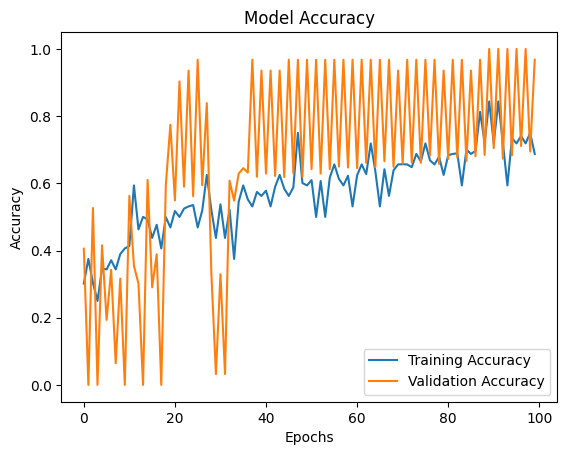

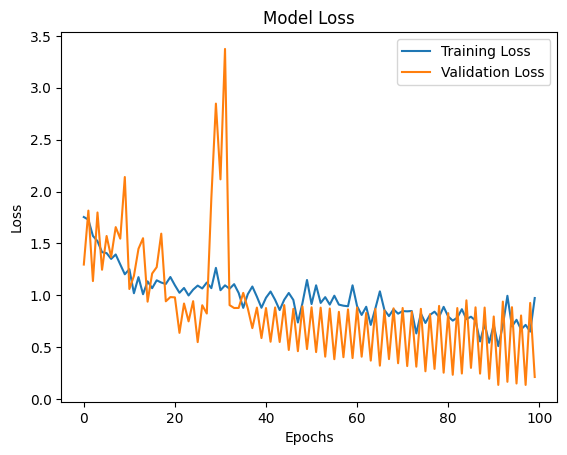

In [ ]:
# Plotting Accuracy
plt.plot(history_scaled.history['accuracy'], label='Training Accuracy')
plt.plot(history_scaled.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting Loss
plt.plot(history_scaled.history['loss'], label='Training Loss')
plt.plot(history_scaled.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

On using the final model which we termed as the better model out of all, we observe a decrease in model performance when the image size is upscaled to 128. There are multiple reasons why this could occur. As image size incerases, the complexity of the image increases, and since we have defined a pretty simple architecture, it may imply worsened performance. This means it may require more number of layers, paramaters and a complex architectural structure to effectively learn the new features.    
While the overall accuracy may have one positive out of this is that the training and testing accuracy are not that far apart, which can imply that the model has generalised well on unseen data. But, we have to keep in mind that this could be a sign of underfitting as well, since our model is not complex.

<br>

In [ ]:
model_scaled.save('model_scaled.keras')

<br>

# 5. Evaluating on Test Data   
All the models are now evaluated on the test data, in specific I have taken random images from the __Testing__ subfolder and used the trained models to predict whether the image is 1 of the 4 classifications of brain tumors. There is no perfect way to choose the best model, but I have simply portrayed the comparisons of the model's ability to predict on unseen data. In fact multiple images can be chosen to test prediction.

# 5.1 Base Model

In [ ]:
model_base=keras.models.load_model('model_base.keras')
model_early=keras.models.load_model('model_early.keras')
model_final=keras.models.load_model('model_final.keras')
model_reduce_lr=keras.models.load_model('model_reduce_lr.keras')
model_reg=keras.models.load_model('model_reg.keras')
model_scaled=keras.models.load_model('model_scaled.keras')
model_xavier=keras.models.load_model('model_xavier.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
The predicted label is: pituitary
Prediction score for pituitary: 0.9950


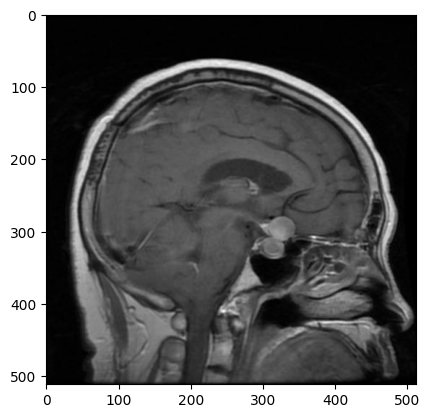

In [ ]:
from tensorflow import keras

from tensorflow.keras.preprocessing import image

# Define a function that predicts images based on the class labels
def predict_image(model, img_path, target_size=(64, 64)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # normalize as trained

    prediction = model_base.predict(img_array)
    class_index = np.argmax(prediction, axis=1)[0]
    class_label = list(train_generator.class_indices.keys())[class_index]
    prediction_score = prediction[0][class_index]

    return class_label, prediction_score

# Predict a new image
img_path = keras.utils.load_img('/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/pituitary/Te-pi_0292.jpg')
plt.imshow(img_path)
img = '/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/pituitary/Te-pi_0292.jpg'
predicted_label, prediction_score = predict_image(model_base, img)
print(f"The predicted label is: {predicted_label}")
print(f"Prediction score for {predicted_label}: {prediction_score:.4f}")

<br>

# 5.2 Model with Regularisation (Batch Normalisation and Dropout)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
The predicted label is: glioma
Prediction score for glioma: 0.9766


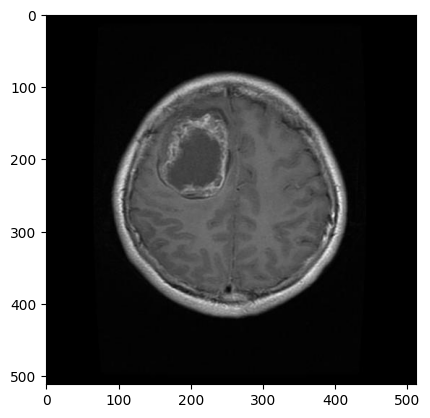

In [ ]:
from tensorflow import keras

from tensorflow.keras.preprocessing import image

# Define a function that predicts images based on the class labels
def predict_image(model, img_path, target_size=(64, 64)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # normalize as trained

    prediction = model_reg.predict(img_array)
    class_index = np.argmax(prediction, axis=1)[0]
    class_label = list(train_generator.class_indices.keys())[class_index]
    prediction_score = prediction[0][class_index]

    return class_label, prediction_score

# Predict a new image
img_path = keras.utils.load_img('/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/glioma/Te-gl_0293.jpg')
plt.imshow(img_path)
img = '/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/glioma/Te-gl_0293.jpg'
predicted_label, prediction_score = predict_image(model_reg, img)
print(f"The predicted label is: {predicted_label}")
print(f"Prediction score for {predicted_label}: {prediction_score:.4f}")

<br>

# 5.3 Model with Regularisation (Early Stopping)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
The predicted label is: notumor
Prediction score for notumor: 0.9940


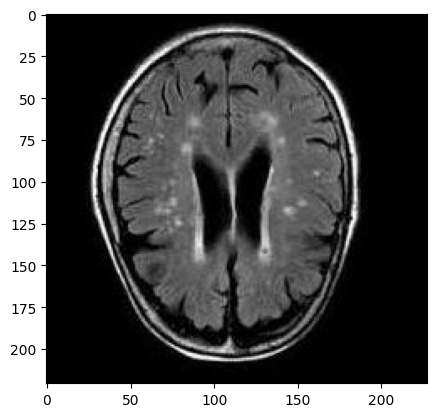

In [ ]:
from tensorflow import keras

from tensorflow.keras.preprocessing import image

# Define a function that predicts images based on the class labels
def predict_image(model, img_path, target_size=(64, 64)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # normalize as trained

    prediction = model_early.predict(img_array)
    class_index = np.argmax(prediction, axis=1)[0]
    class_label = list(train_generator.class_indices.keys())[class_index]
    prediction_score = prediction[0][class_index]

    return class_label, prediction_score

# Predict a new image
img_path = keras.utils.load_img('/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/notumor/Te-no_0185.jpg')
plt.imshow(img_path)
img = '/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/notumor/Te-no_0185.jpg'
predicted_label, prediction_score = predict_image(model_early, img)
print(f"The predicted label is: {predicted_label}")
print(f"Prediction score for {predicted_label}: {prediction_score:.4f}")

<br>

# 5.4 Model with Reduced Learning Rate

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
The predicted label is: pituitary
Prediction score for pituitary: 0.9886


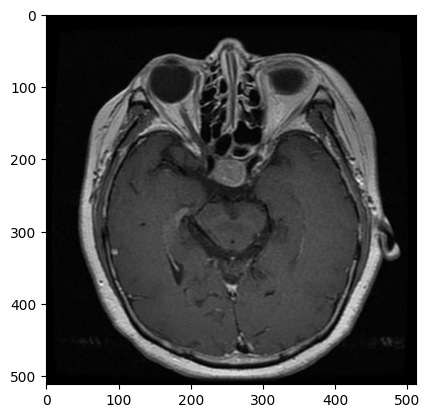

In [ ]:
from tensorflow import keras

from tensorflow.keras.preprocessing import image

# Define a function that predicts images based on the class labels
def predict_image(model, img_path, target_size=(64, 64)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # normalize as trained

    prediction = model_reduce_lr.predict(img_array)
    class_index = np.argmax(prediction, axis=1)[0]
    class_label = list(train_generator.class_indices.keys())[class_index]
    prediction_score = prediction[0][class_index]

    return class_label, prediction_score

# Predict a new image
img_path = keras.utils.load_img('/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/pituitary/Te-pi_0139.jpg')
plt.imshow(img_path)
img = '/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/pituitary/Te-pi_0139.jpg'
predicted_label, prediction_score = predict_image(model_reduce_lr, img)
print(f"The predicted label is: {predicted_label}")
print(f"Prediction score for {predicted_label}: {prediction_score:.4f}")

<br>

# 5.5 Model with Xavier Initialisation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
The predicted label is: meningioma
Prediction score for meningioma: 0.8194


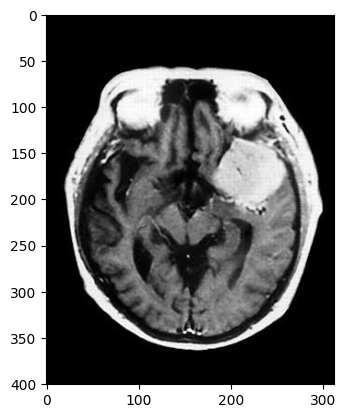

In [ ]:
from tensorflow import keras

from tensorflow.keras.preprocessing import image

# Define a function that predicts images based on the class labels
def predict_image(model, img_path, target_size=(64, 64)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # normalize as trained

    prediction = model_xavier.predict(img_array)
    class_index = np.argmax(prediction, axis=1)[0]
    class_label = list(train_generator.class_indices.keys())[class_index]
    prediction_score = prediction[0][class_index]

    return class_label, prediction_score

# Predict a new image
img_path = keras.utils.load_img('/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/meningioma/Te-me_0034.jpg')
plt.imshow(img_path)
img = '/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/meningioma/Te-me_0034.jpg'
predicted_label, prediction_score = predict_image(model_xavier, img)
print(f"The predicted label is: {predicted_label}")
print(f"Prediction score for {predicted_label}: {prediction_score:.4f}")

<br>

# 5.6 Final Model


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
The predicted label is: pituitary
Prediction score for pituitary: 0.9903


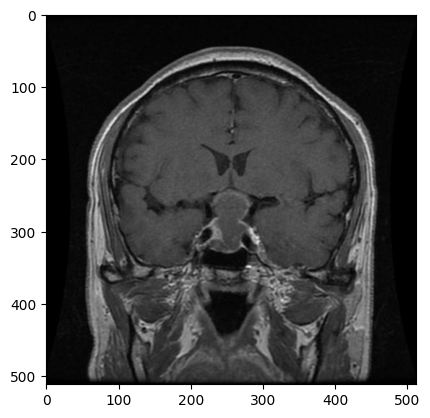

In [ ]:
from tensorflow import keras

from tensorflow.keras.preprocessing import image

# Define a function that predicts images based on the class labels
def predict_image(model, img_path, target_size=(64, 64)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # normalize as trained

    prediction = model_final.predict(img_array)
    class_index = np.argmax(prediction, axis=1)[0]
    class_label = list(train_generator.class_indices.keys())[class_index]
    prediction_score = prediction[0][class_index]

    return class_label, prediction_score

# Predict a new image
img_path = keras.utils.load_img('/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/pituitary/Te-pi_0295.jpg')
plt.imshow(img_path)
img = '/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/pituitary/Te-pi_0295.jpg'
predicted_label, prediction_score = predict_image(model_final, img)
print(f"The predicted label is: {predicted_label}")
print(f"Prediction score for {predicted_label}: {prediction_score:.4f}")

<br>

# 5.7 Model for Scaled Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step
The predicted label is: pituitary
Prediction score for pituitary: 0.7886


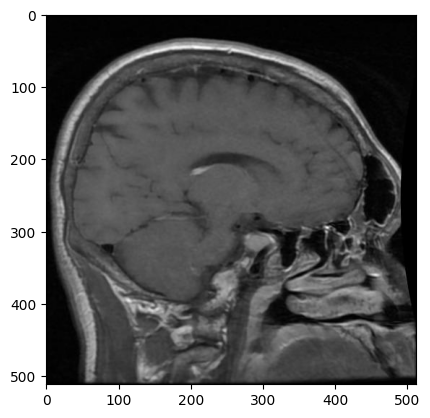

In [ ]:
from tensorflow import keras

from tensorflow.keras.preprocessing import image

# Define a function that predicts images based on the class labels
def predict_image(model, img_path, target_size=(128, 128)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # normalize as trained

    prediction = model_scaled.predict(img_array)
    class_index = np.argmax(prediction, axis=1)[0]
    class_label = list(train_generator.class_indices.keys())[class_index]
    prediction_score = prediction[0][class_index]

    return class_label, prediction_score

# Predict a new image
img_path = keras.utils.load_img('/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/pituitary/Te-pi_0282.jpg')
plt.imshow(img_path)
img = '/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/pituitary/Te-pi_0282.jpg'
predicted_label, prediction_score = predict_image(model_scaled, img)
print(f"The predicted label is: {predicted_label}")
print(f"Prediction score for {predicted_label}: {prediction_score:.4f}")

<br>

# 5.8 Example of any of the model's correct vs incorrect prediction

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Correct Prediction:
True Label: glioma
Predicted Label: glioma
Class Probabilities:
  glioma: 0.7960
  meningioma: 0.1198
  notumor: 0.0351
  pituitary: 0.0491

Incorrect Prediction:
True Label: glioma
Predicted Label: pituitary
Class Probabilities:
  glioma: 0.0436
  meningioma: 0.4461
  notumor: 0.0028
  pituitary: 0.5075



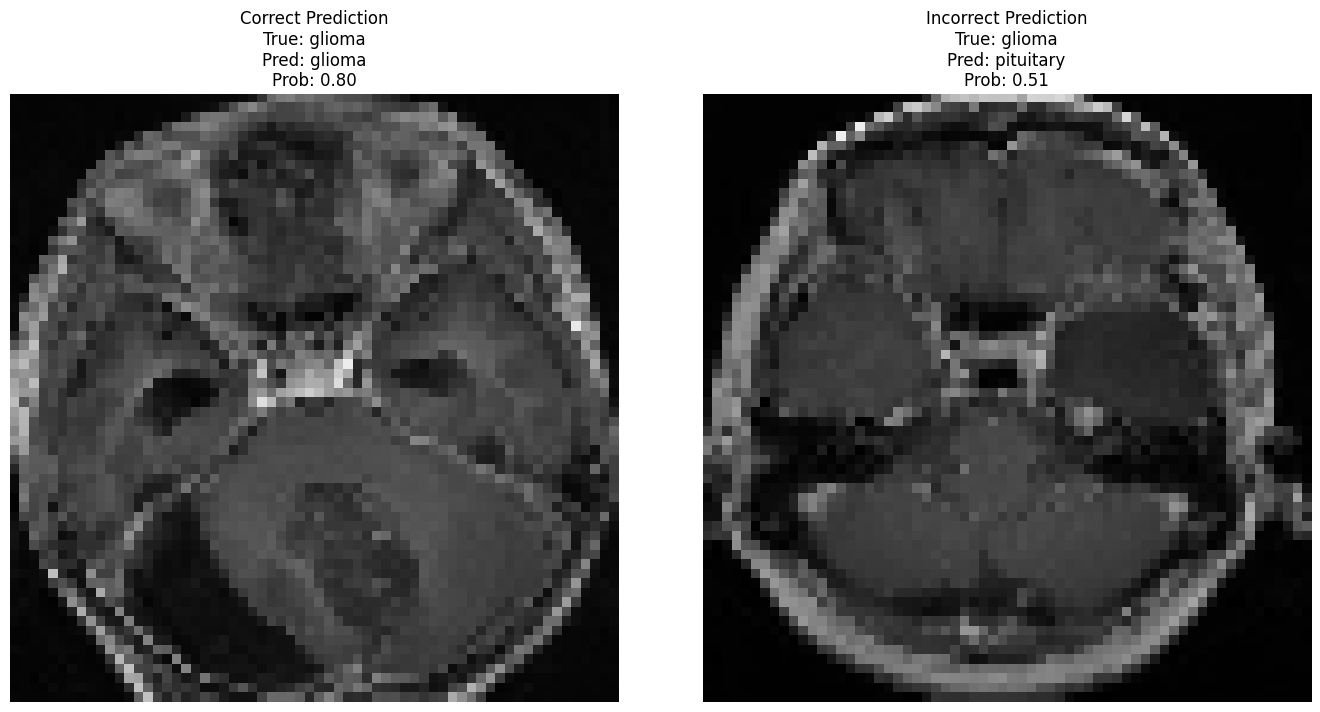

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
import time
# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Predict on the test dataset
predictions = model_final.predict(test_generator)

predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Find a correct prediction
correct_idx = np.where(predicted_classes == true_classes)[0][0]
correct_image = test_generator[correct_idx][0][0]
correct_true_label = class_labels[true_classes[correct_idx]]
correct_predicted_label = class_labels[predicted_classes[correct_idx]]
correct_probability = predictions[correct_idx, predicted_classes[correct_idx]]

# Find an incorrect prediction
incorrect_idx = np.where(predicted_classes != true_classes)[0][0]
incorrect_image = test_generator[incorrect_idx][0][0]
incorrect_true_label = class_labels[true_classes[incorrect_idx]]
incorrect_predicted_label = class_labels[predicted_classes[incorrect_idx]]
incorrect_probability = predictions[incorrect_idx, predicted_classes[incorrect_idx]]

# Print probability distributions for correct and incorrect predictions
print("Correct Prediction:")
print(f"True Label: {correct_true_label}")
print(f"Predicted Label: {correct_predicted_label}")
print("Class Probabilities:")
for i, label in enumerate(class_labels):
    print(f"  {label}: {predictions[correct_idx, i]:.4f}")
print()

print("Incorrect Prediction:")
print(f"True Label: {incorrect_true_label}")
print(f"Predicted Label: {incorrect_predicted_label}")
print("Class Probabilities:")
for i, label in enumerate(class_labels):
    print(f"  {label}: {predictions[incorrect_idx, i]:.4f}")
print()

# Plot correct and incorrect predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Correct prediction
axes[0].imshow(correct_image)
axes[0].set_title(
    f"Correct Prediction\nTrue: {correct_true_label}\nPred: {correct_predicted_label}\nProb: {correct_probability:.2f}"
)
axes[0].axis('off')

# Incorrect prediction
axes[1].imshow(incorrect_image)
axes[1].set_title(
    f"Incorrect Prediction\nTrue: {incorrect_true_label}\nPred: {incorrect_predicted_label}\nProb: {incorrect_probability:.2f}"
)
axes[1].axis('off')

plt.tight_layout()
plt.show()

# 7. Conclusion    

On observing the various models i.e., base model, adding regularisation, early stopping, reduced learning rate scheduler and weight initialisation, it is observed that there are similar characteristics to most models, one being the representations of the training and validation accuracies and scores. On graphical visualisation, we can see an oscillatory behaviour which could be caused by multiple reasons. One could be due to the learning rate being 0.001, causing instability and large fluctuations, and it is observed in the graph for reduced learning rate, a more stable and less oscillatory trend is observed, especially with respect to the training accuracies and losses. Since I have not investiagted on the batch size, this could also be the reason as smaller batch sizes can introduce noise in gradient updates.
<br>   
The other thing to observe is that on random selection of images from the testing folder, it is clear to see that all models perform well except maybe the model with regularisation. Now, since we have chosen the images at random, it could be that this model predicts other images well, but this cannot be guaranteed. In fact even for the "well-performing" models, prediction results as seen here is not conclusive proof that the model predicts every kind of image accurately. But, computationally this will be extremely tedious, and hence why it is not included.
<br>   
There is obviously no "best" model that ever be made, but out of the sample of models we have created, it is obvious by the training and testing accuracy scores that the __Reduced Learning Rate Model__ is a viable option, but in terms of overall performance of the model considering the fact that multiple parameters have been used to improve convergence, attempt to mitigate the problem of overfitting and enhance training stability and performance, the final model is considered to be relatively better.   
<br>
As a direct consequence of choosing the "best" model, the upscaled version of the images from 64x64 to 128x128 are subjected to prediction by training the final model on it and as observed, due to its simple architecture and inability to capture complex relationships between features of images, the accruacy scores drop by ~10% (we are interested in the model's generalisation on unseen data and hence consider the training accuracy). Better data augmentation, deeper understanding and investigation of parameter tuning, and a better computational environment can defintely result in a naunced understanding of model performance and subsequently help improve model performance. The scope of this project would be to next increase the amount of data by lets say x1000 and analyze changes to computational complexity, time and model creation and performance.  
